# Mixtures and MCMC

##### Keywords: supervised learning, semi-supervised learning, unsupervised learning, mixture model, gaussian mixture model, pymc3, label-switching, identifiability, normal distribution, pymc3 potentials

We now do a study of learning mixture models with MCMC. We have already done this in the case of the Zero-Inflated Poisson Model, and will stick to Gaussian Mixture models for now.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm
import theano.tensor as tt

## Mixture of 2 Gaussians, the old faithful data

We start by considering waiting times from the Old-Faithful Geyser at Yellowstone National Park.

In [2]:
ofdata=pd.read_csv("data/oldfaithful.csv")
ofdata.head()

,eruptions,waiting
0,3.600,79
1,1.800,54
2,3.333,74
3,2.283,62
4,4.533,85


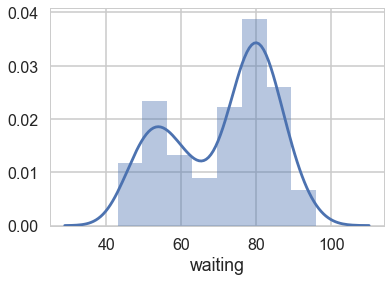

In [3]:
sns.distplot(ofdata.waiting);

Visually, there seem to be two components to the waiting time, so let us model this using a mixture of two gaussians. Remember that this is a unsupervized model, and all we are doing is modelling $p(x)$ , with the assumption that there are two clusters and a hidden variable $z$ that indexes them.

In [4]:
with pm.Model() as ofmodel:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    assignment = pm.Categorical("assignment", p, 
                                shape=ofdata.shape[0])
    sds = pm.Uniform("sds", 0, 40, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([50, 80]), 
                        sd=np.array([20, 20]), 
                        shape=2)
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=centers[assignment], sd=sds[assignment], observed=ofdata.waiting)

In [5]:
with ofmodel:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.CategoricalGibbsMetropolis(vars=[assignment])
    oftrace_full = pm.sample(10000, step=[step1, step2])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds_interval__]
>>Metropolis: [p_interval__]
>CategoricalGibbsMetropolis: [assignment]
100%|██████████| 10500/10500 [06:33<00:00, 26.70it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


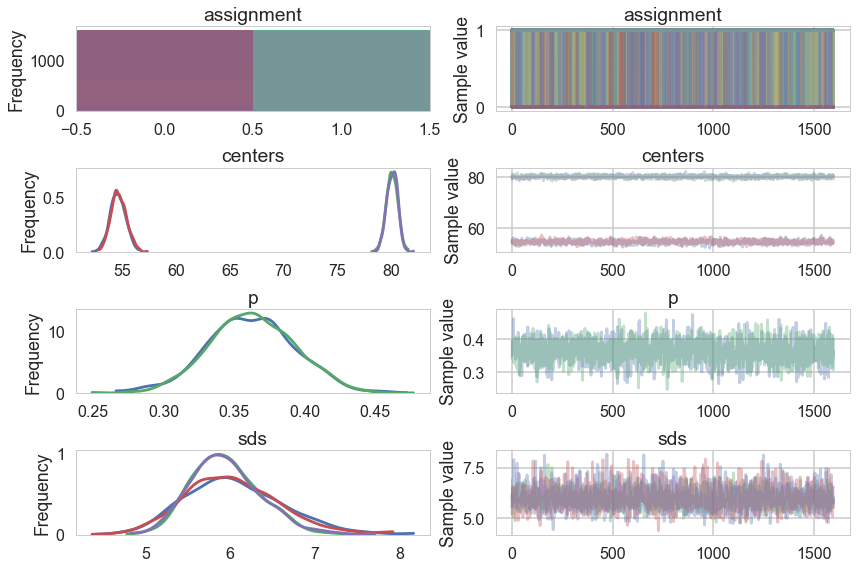

In [6]:
oftrace = oftrace_full[2000::5]
pm.traceplot(oftrace);

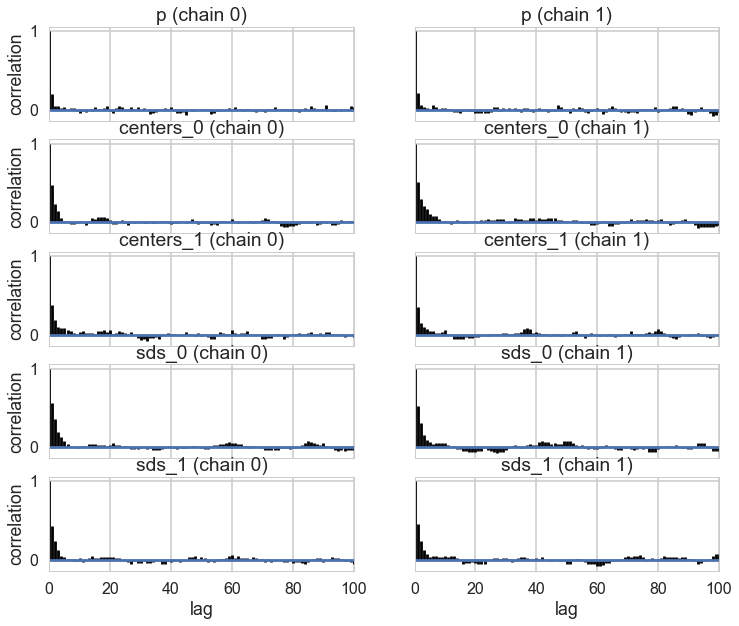

In [7]:
pm.autocorrplot(oftrace, varnames=['p', 'centers', 'sds']);

In [8]:
oftrace['centers'].mean(axis=0)

array([ 54.62894558,  80.09151182])

We can visualize the two clusters, suitably scales by the category-belonging probability by taking the posterior means. Note that this misses any smearing that might go into making the posterior predictive

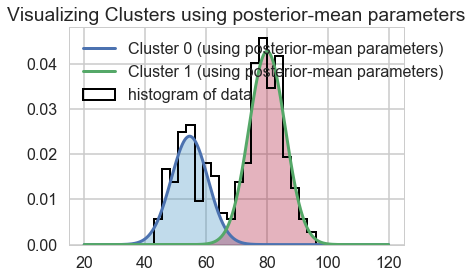

In [9]:
from scipy.stats import norm
x = np.linspace(20, 120, 500)
# for pretty colors later in the book.
colors = ["#348ABD", "#A60628"] if oftrace['centers'][-1, 0] > oftrace['centers'][-1, 1] \
    else ["#A60628", "#348ABD"]

posterior_center_means = oftrace['centers'].mean(axis=0)
posterior_std_means = oftrace['sds'].mean(axis=0)
posterior_p_mean = oftrace["p"].mean()

plt.hist(ofdata.waiting, bins=20, histtype="step", normed=True, color="k",
     lw=2, label="histogram of data")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");

## A tetchy 3 Gaussian Model

Let us set up our data.

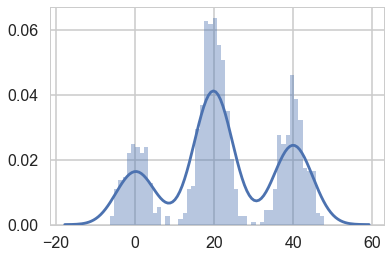

In [29]:
mu_true = np.array([0, 20, 40])
sigma_true = np.array([3, 3, 3])
lambda_true = np.array([.2, .5, .3])
n = 1000
from scipy.stats import multinomial
# Simulate from each distribution according to mixing proportion psi
z = multinomial.rvs(1, lambda_true, size=n)
data=np.array([np.random.normal(mu_true[i.astype('bool')][0], sigma_true[i.astype('bool')][0]) for i in z])
sns.distplot(data, bins=50);

In [30]:
np.savetxt("data/3g.dat", data)

In a similar way to before, we set up our sampling. The main difference is the direct use of the Dirichlet as a prior.

In [42]:
with pm.Model() as mof:
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=3)


    # cluster centers
    means = pm.Normal('means', mu=[0,20,40], sd=5, shape=3)


    sds = pm.Uniform('sds', lower=0, upper=20, shape=3)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=data.shape[0])

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=sds[category],
                       observed=data)


In [43]:
with mof:
    step1 = pm.Metropolis(vars=[p, sds, means])
    step2 = pm.ElemwiseCategorical(vars=[category])
    tripletrace_full = pm.sample(10000, step=[step1, step2], chains=1)

//anaconda/envs/py3l/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Sequential sampling (1 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [means]
>>Metropolis: [sds_interval__]
>>Metropolis: [p_stickbreaking__]
>ElemwiseCategorical: [category]
100%|██████████| 10500/10500 [03:38<00:00, 48.14it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


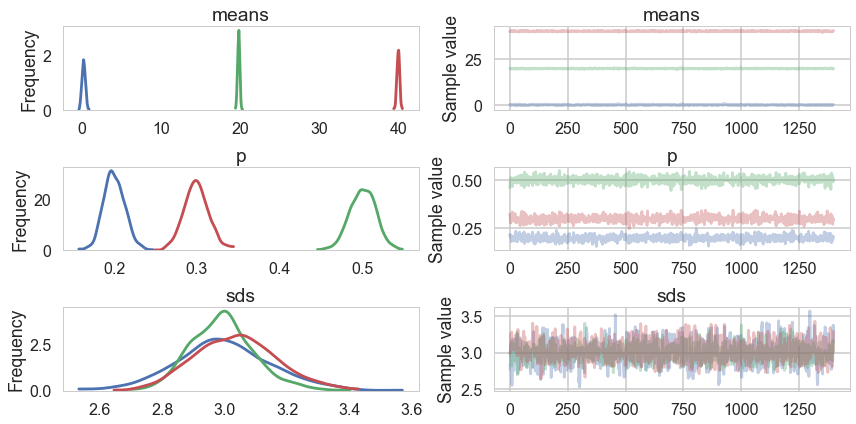

In [44]:
trace_mof=tripletrace_full[3000::5]
pm.traceplot(trace_mof, varnames=["means", "p", "sds"]);

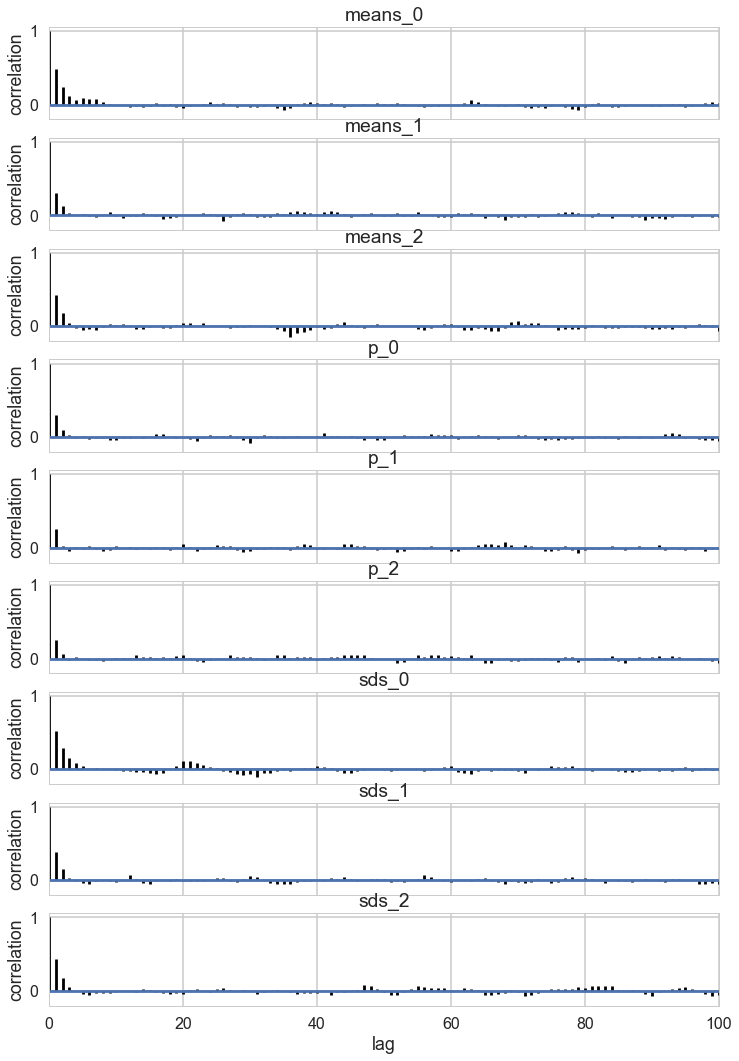

In [45]:
pm.autocorrplot(trace_mof, varnames=['means', 'p', 'sds']);

## Problems with clusters and sampling

Some of the traces seem ok, but the autocorrelation is quite bad. This is because there are major problems with using MCMC for clustering.

These are firstly, the lack of parameter identifiability (the so called label-switching problem) and secondly, the multimodality of the posteriors.

We have seen non-identifiability before. Switching labels on the means and z's, for example, does not change the likelihoods. The problem with this is that cluster parameters cannot be compared across chains: what might be a cluster parameter in one chain could well belong to the other cluster in the second chain. Even within a single chain, indices might swap leading to a telltale back and forth in the traces for long chains or data not cleanly separated.

Also, the (joint) posteriors can be highly multimodal. One form of multimodality is the non-identifiability, though even without identifiability issues the posteriors are highly multimodal.

To quote the Stan manual:
>Bayesian inference fails in cases of high multimodality because there is no way to visit all of the modes in the posterior in appropriate proportions and thus no way to evaluate integrals involved in posterior predictive inference.
In light of these two problems, the advice often given in fitting clustering models is to try many different initializations and select the sample with the highest overall probability. It is also popular to use optimization-based point estimators such as expectation maximization or variational Bayes, which can be much more efficient than sampling-based approaches.

In [46]:
trace_mof['category'].mean()

1.09962

### Some mitigation via potentials in pymc3

The idea behind a `Potential` is something that is not part of the likelihood, but enforces a constraint by setting the probability to 0 if the constraint is violated. We use it here to give each cluster some membership and to order the means to remove the non-identifiability problem. See below for how its used.

But this is not a panacea. Sampling is still vety hard.


In [47]:
import theano.tensor as tt
with pm.Model() as mof2:
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=3)
    # ensure all clusters have some points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))

    # cluster centers
    means = pm.Normal('means', mu=[0, 20, 40], sd=5, shape=3)

    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))
                                         
    # measurement error
    sds = pm.Uniform('sds', lower=0, upper=20, shape=3)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=data.shape[0])

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=sds[category],
                       observed=data)


In [48]:
with mof2:
    step1 = pm.Metropolis(vars=[p, sds, means])
    step2 = pm.ElemwiseCategorical(vars=[category])
    tripletrace_full2 = pm.sample(10000, step=[step1, step2], chains=1)

//anaconda/envs/py3l/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Sequential sampling (1 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [means]
>>Metropolis: [sds_interval__]
>>Metropolis: [p_stickbreaking__]
>ElemwiseCategorical: [category]
100%|██████████| 10500/10500 [03:42<00:00, 47.24it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


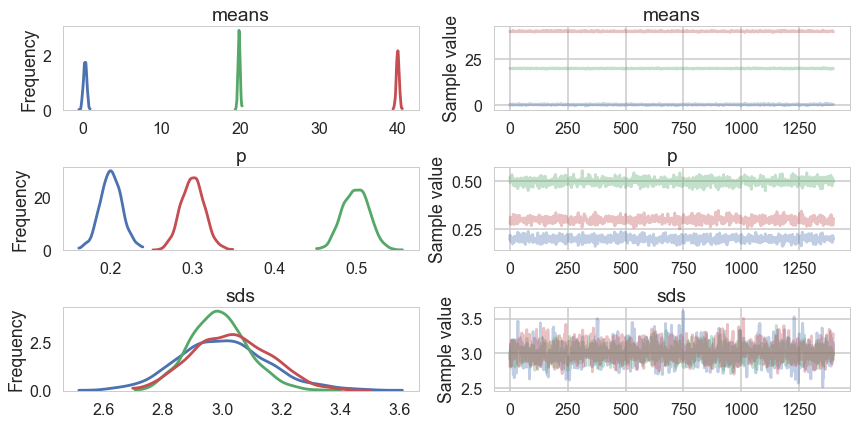

In [49]:
trace_mof2 = tripletrace_full2[3000::5]
pm.traceplot(trace_mof2, varnames=["means", "p", "sds"]);

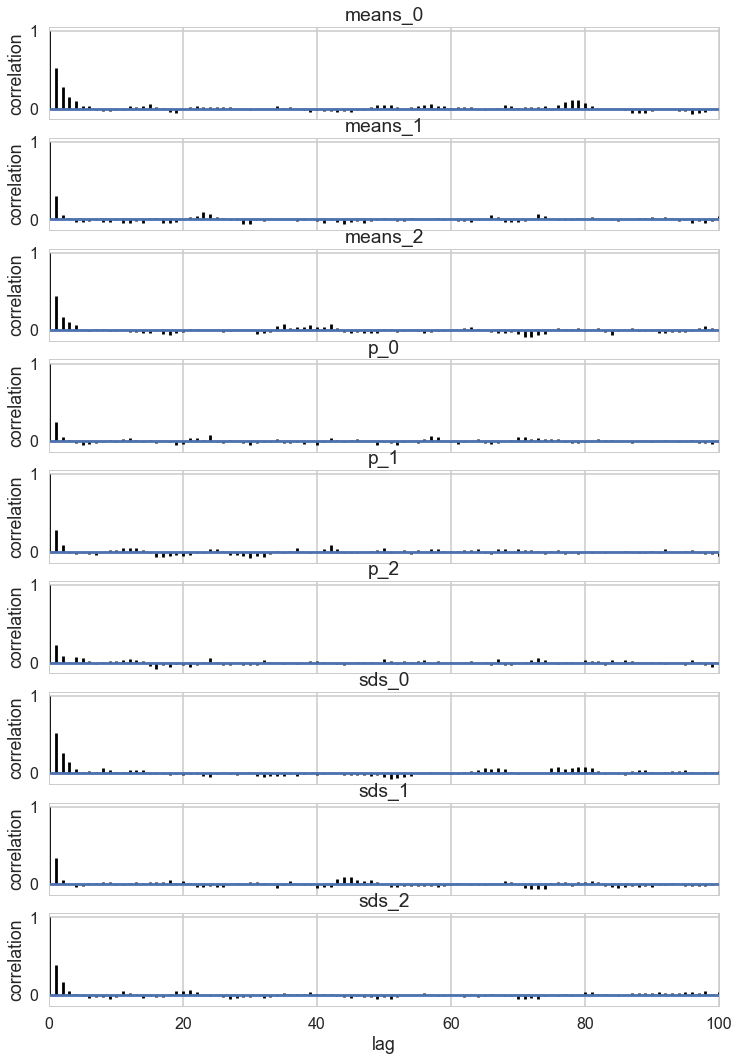

In [50]:
pm.autocorrplot(trace_mof2, varnames=["means", "p", "sds"]);